In [1]:
import librosa
import librosa.feature
import librosa.display
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
import IPython.display as ipd

In [2]:
def display_mfcc(sound):
    y, _ = librosa.load(sound)
    mfcc = librosa.feature.mfcc(y)

    plt.figure(figsize=(16, 6))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(sound)
    plt.tight_layout()
    plt.show()

## Aedes Aegypti Betina

In [3]:
path1='D:/Milik Pribadi/Pembelajaran ITB/Physics Engineering/Daniel Beltsazar/Fisika Teknik/Tingkat IV/Semester Ganjil/Metoda Penelitian/TA/Data/Coding/Training/aegypti betina 1.wav'

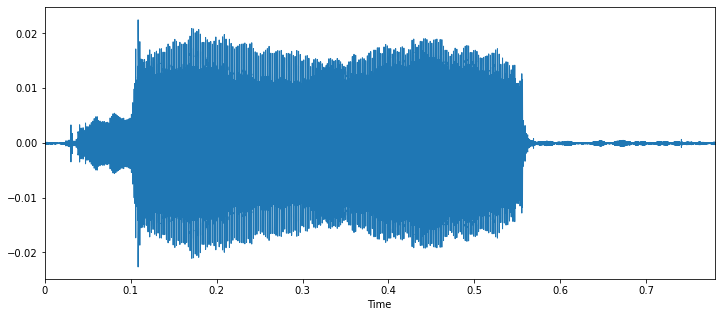

In [4]:
x, sr = librosa.load(path1)

# Plot the sample.
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

In [5]:
ipd.Audio(path1)

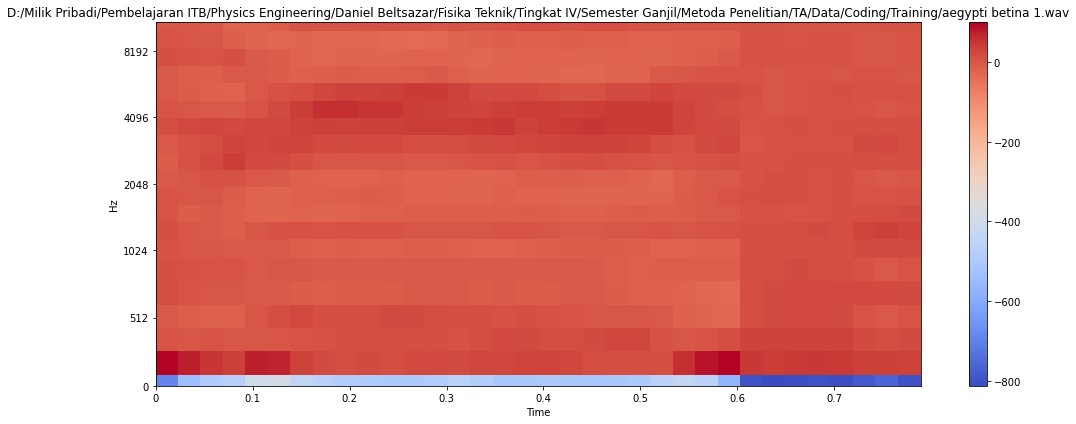

In [6]:
display_mfcc(path1)

## Aedes Aegypti Jantan

In [7]:
path2='D:/Milik Pribadi/Pembelajaran ITB/Physics Engineering/Daniel Beltsazar/Fisika Teknik/Tingkat IV/Semester Ganjil/Metoda Penelitian/TA/Data/Coding/Training/aegypti jantan 1.wav'

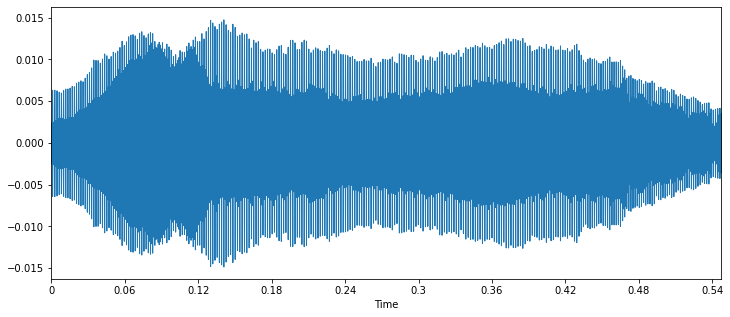

In [8]:
x, sr = librosa.load(path2)

# Plot the sample.
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

In [9]:
ipd.Audio(path2)

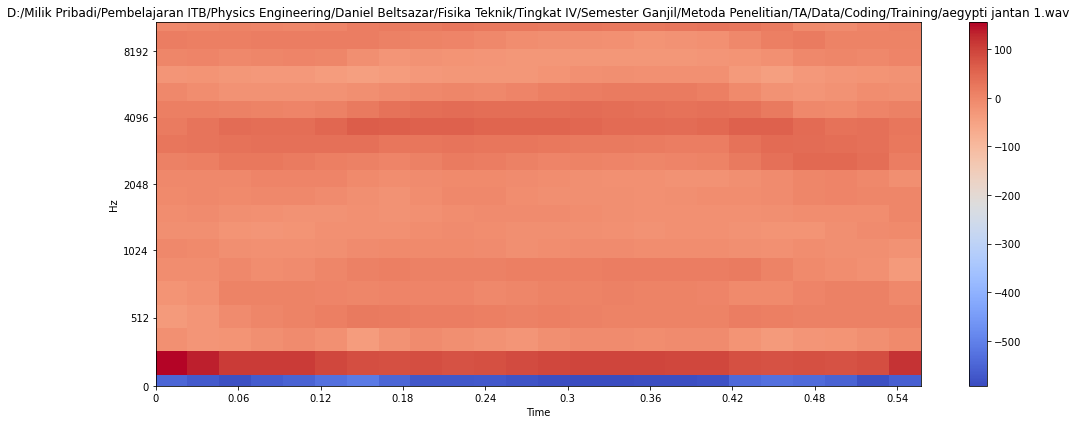

In [10]:
display_mfcc(path2)

## Albo Betina

In [11]:
path3 = 'D:/Milik Pribadi/Pembelajaran ITB/Physics Engineering/Daniel Beltsazar/Fisika Teknik/Tingkat IV/Semester Ganjil/Metoda Penelitian/TA/Data/Coding/Training/albo betina 1.wav'

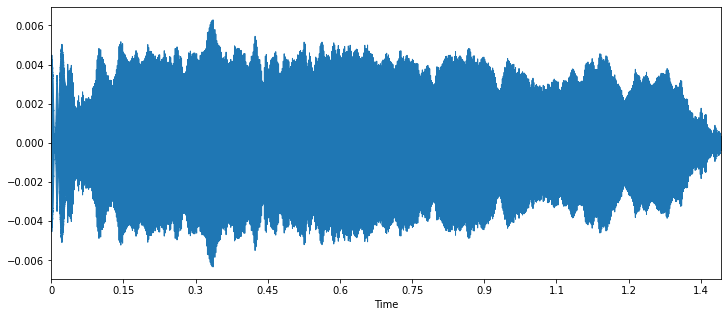

In [12]:
x, sr = librosa.load(path3)

# Plot the sample.
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

In [13]:
ipd.Audio(path3)

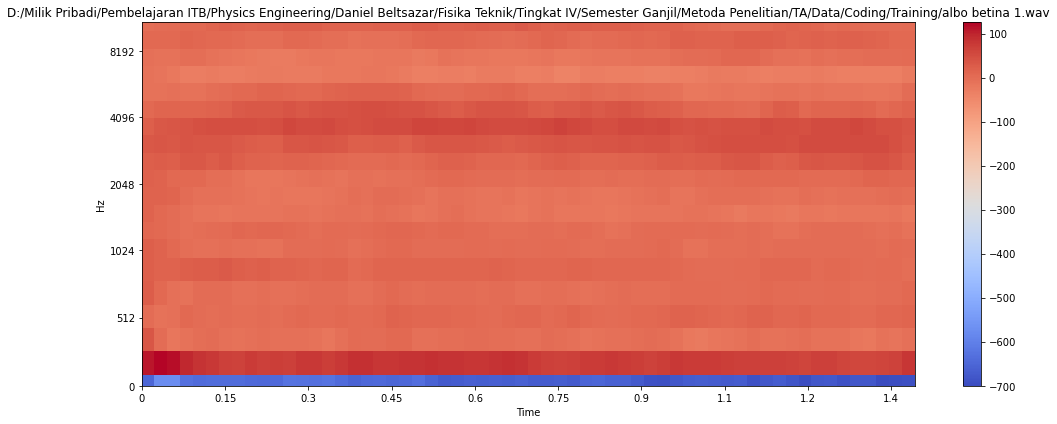

In [14]:
display_mfcc(path3)

## Albo Jantan

In [15]:
path4 = 'D:/Milik Pribadi/Pembelajaran ITB/Physics Engineering/Daniel Beltsazar/Fisika Teknik/Tingkat IV/Semester Ganjil/Metoda Penelitian/TA/Data/Coding/Training/albo jantan 1.wav'

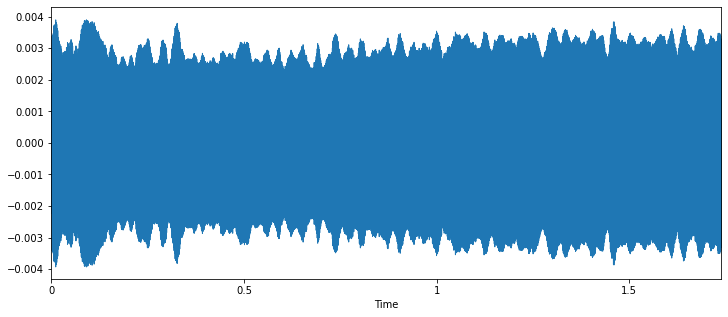

In [16]:
x, sr = librosa.load(path4)

# Plot the sample.
plt.figure(figsize=(12, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

In [17]:
ipd.Audio(path4)

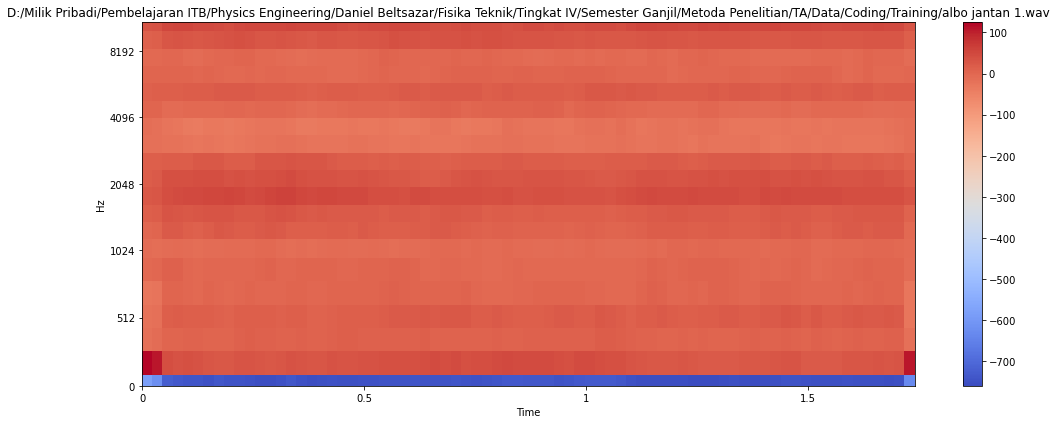

In [18]:
display_mfcc(path4)

## Ekstrak data dan Neural Network

In [19]:
def extract_features_sound(f):
    y, _ = librosa.load(f)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))

    return np.ndarray.flatten(mfcc)[:100]

In [20]:
def generate_features_and_labels():
    all_features = []
    all_labels = []

    jenis_nyamuk = ['Aedes Aegypti','Aedes Albo']
    for jenis in jenis_nyamuk:
        sound_files = glob.glob('Data binary/'+jenis+'/*.wav')
        print('Processing %d sound in %s jenis nyamuk...' % (len(sound_files), jenis))
        for f in sound_files:
            features = extract_features_sound(f)
            all_features.append(features)
            all_labels.append(jenis)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [21]:
features, labels = generate_features_and_labels()

Processing 180 sound in Aedes Aegypti jenis nyamuk...
Processing 180 sound in Aedes Albo jenis nyamuk...


In [22]:
print(np.shape(features))
print(np.shape(labels))

training_split = 0.8

# last column has genre, turn it into unique ids
alldata = np.column_stack((features, labels))

np.random.shuffle(alldata)
splitidx = int(len(alldata) * training_split)
train, test = alldata[:splitidx,:], alldata[splitidx:,:]

print(np.shape(train))
print(np.shape(test))

train_input = train[:,:-2]
train_labels = train[:,-2:]

test_input = test[:,:-2]
test_labels = test[:,-2:]

print(np.shape(train_input))
print(np.shape(train_labels))

(360, 100)
(360, 2)
(288, 102)
(72, 102)
(288, 100)
(288, 2)


In [23]:
seed = 7
np.random.seed(seed)
from keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.constraints import maxnorm
model =  Sequential()
model.add(Dense(200,input_dim=np.shape(train_input)[1],activation='relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(2, activation= 'sigmoid'))
optimizer = RMSprop(lr=0.01, momentum=0.4)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

model.fit(train_input, train_labels, epochs=150, batch_size=10,
          validation_split=0.2)

loss, acc = model.evaluate(test_input, test_labels, batch_size=20)

print("Done!")
print("Loss: %.4f, accuracy: %.4f" % (loss, acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 41,302
Trainable params: 40,902
Non-trainable params: 400
_________________________________________________________________
None
Epoch 1/150
23/23 [==============================] - 0s 14ms/step - loss: 1.0459 - accuracy: 0.6000 - val_loss: 3.6015 - val_accuracy: 0.4483
Epoch 2/150
23/23 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.5913 - 

Epoch 110/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5631 - accuracy: 0.7174 - val_loss: 2.3589 - val_accuracy: 0.5690
Epoch 111/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5445 - accuracy: 0.7087 - val_loss: 1.7239 - val_accuracy: 0.5690
Epoch 112/150
23/23 [==============================] - 0s 3ms/step - loss: 0.5573 - accuracy: 0.7348 - val_loss: 1.0986 - val_accuracy: 0.5862
Epoch 113/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4998 - accuracy: 0.7565 - val_loss: 1.5226 - val_accuracy: 0.5862
Epoch 114/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5428 - accuracy: 0.7174 - val_loss: 0.6287 - val_accuracy: 0.5862
Epoch 115/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5299 - accuracy: 0.7174 - val_loss: 0.5339 - val_accuracy: 0.6897
Epoch 116/150
23/23 [==============================] - 0s 3ms/step - loss: 0.4882 - accuracy: 0.7565 - val_loss: 0.5935 - val_accuracy: 0.6552

In [24]:
model.predict(test_input[:1])

array([[0.404385  , 0.63486964]], dtype=float32)

In [25]:
from keras.models import load_model
model.save('model klasifikasi binary 2.h5')
# my_model = load_model('my_model.h5')